In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import pandas as pd
import seaborn.apionly as sns
plt.style.use('ggplot')
sns.set_style('ticks')
import re
import matplotlib.ticker as ticker
# Enable inline plotting  
%matplotlib inline

In [3]:
print ('Python version ' + sys.version)
print ('Pandas version ' + pd.__version__)
print ('Numpy version ' + np.__version__)

Python version 3.5.5 | packaged by conda-forge | (default, Jul 23 2018, 23:45:11) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
Pandas version 0.23.4
Numpy version 1.15.2


# Output from Production Run 

In [4]:
# Data1 represents the time per rank per repeat for each component inside the RMSD function
data1='data-comm-updated-rmsd/data1.txt'
# Data2 represents the timing of the different sections of the code per rank per repeat for each run 
data2='data-comm-updated-rmsd/data2.txt'

# Load Data

In [6]:
# Load overal timing into a dataframe called df1 (use data1.txt)
df1 = pd.read_csv(data1, delimiter=' ', header=None, names=['blocks', 'repeat', 'P_ID', 't_comp', 't_IO', 't_IO_plus_t_comp',
                                                            't_end_loop', 't_init']) 
                                                            # t_init is t_opening_trajectory in the paper
df1_copy = df1 

In [7]:
df1 = pd.concat([df1.groupby('blocks', as_index=False).mean(), df1.groupby('blocks', as_index=False).max().loc[:,'t_IO_plus_t_comp'], 
                 df1.groupby('blocks', as_index=False).std().loc[:,['t_comp','t_IO']]],axis=1)

In [8]:
df1.columns = ['blocks', 'repeat', 'P_ID', 't_comp', 't_IO', 't_IO_plus_t_comp_mean','t_end_loop', 't_init', 
               't_IO_plus_t_comp_max','std_comp','std_IO']

In [9]:
f = open(data2, 'r')
l = f.readlines()

# Data Preparation

In [10]:
def Flatten(TheList):
    a = str(TheList)
    b,crap = re.subn(r'(\]|\[)', '\n', a)
    c = b.split('\n')

    return(c)

In [11]:
def Flatten1(TheList):
    a = TheList
    b,crap = re.subn(r',', '', a)

    return(b)

In [12]:
## Some modification to the input format to convert it to the desired format

l1 = []
for l_i in l:
    d = Flatten(l_i)
    b = []
    for lng in range(len(d)):
        if(len(d[lng])>1):b.append(d[lng])      
       
    b1 = Flatten1(b[1])   
    b1 = list(map(float, b1.split()))
    a1 = b[0].split(' ')
    a1.remove('')
    a1 = list(map(int, a1))
    l1.append((a1 + b1))

# Data Post-Processing

In [13]:
# Load timing per N_p per repeat into a dataframe called df2 (use data2.txt)
df2 = pd.DataFrame(l1, index=None, columns=None)

In [14]:
# df_t_total, df_comm, df_comp contains timing for all ranks across all repeats and all N_p
ind = []                # Indices for Total number of ranks and repeat
df_comm = []            # Communication time 
df_comp = []            # Compute time
df_t_total = []         # Total time for the task
for name, group in df2.groupby([0,1]):
    group.index = range(6)
    ind.append(group.iloc[0,:1])
    df_t_total.append(group.iloc[0,2:])
    df_comm.append(group.loc[3])
    df_comp.append(group.loc[5])

In [15]:
# Communication time averaged over all ranks for each run
df_comm1 = pd.DataFrame(df_comm).loc[2:].groupby(0, as_index=False).mean()  

In [16]:
# Compute time averaged over all ranks for each run
df_comp1 = pd.DataFrame(df_comp).loc[2:].groupby(0, as_index=False).mean()

In [17]:
# Total time averaged over all repeats for each N_p
df_t_tot1 = pd.concat([pd.DataFrame(ind, index=range(len(ind))), 
                       pd.DataFrame(df_t_total, index=range(len(ind)))], axis=1).loc[2:].groupby(0, as_index=False).mean() 

In [18]:
# Total time for each repeat and each N_p
df_t_tot_rank = pd.concat([pd.DataFrame(ind, index=range(len(ind))), pd.DataFrame(df_t_total, index=range(len(ind)))], axis=1)

In [19]:
# Communication time for each repeat and each N_p
df_comm_rank = pd.DataFrame(df_comm, index=range(len(ind)))

In [20]:
# Compute time for each repeat and each N_p
df_comp_rank = pd.DataFrame(df_comp, index=range(len(ind)))

In [21]:
# Max value of each timing across all ranks per N_p per repeat 
df_max_Np = df1_copy.groupby(['blocks','repeat'], as_index=False).max() 

In [22]:
# Max value of each timing across all ranks per N_p per repeat AVERAGED OVER REPEATS
df_avg_repeat = df_max_Np.groupby('blocks', as_index=False).mean()

In [23]:
# Standard deviation for df_avg_repeat
df_std_repeat = df_max_Np.groupby('blocks', as_index=False).std().drop(['blocks','repeat','P_ID'],axis=1)
df_std_repeat.columns = ['std_t_comp','std_t_IO','std_t_IO_plus_t_comp','std_t_end_loop','std_t_init']

In [24]:
# Max value of communication across all ranks per N_p per repeat 
df_comm_max_repeat = pd.concat([df_comm_rank.loc[:,:1],df_comm_rank.loc[:,2:].max(axis=1)],axis=1)
df_comm_max_repeat.columns = [0,1,2]

In [25]:
df_comm_max_avg_repeat = df_comm_max_repeat.groupby(0, as_index=False).mean()
df_comm_max_std_repeat = df_comm_max_repeat.groupby(0, as_index=False).std()

In [26]:
# Concat all timing into one single dataframe.
df_avg_repeat = pd.concat([df_avg_repeat,df_comm_max_avg_repeat[2]],axis=1)
df_avg_repeat.columns = [u'blocks', u'repeat', u'P_ID', u't_comp', u't_IO', u't_IO_plus_t_comp',
                         u't_end_loop', u't_init','Communication']

In [27]:
# Calculate standard deviation for all timings in df_avg_repeat
df_std_repeat = df_max_Np.groupby('blocks', as_index=False).std().drop(['blocks','repeat','P_ID'],axis=1)
df_std_repeat = pd.concat([df_std_repeat,df_comm_max_std_repeat[2]],axis=1)
df_std_repeat.columns = ['std_t_comp','std_t_IO','std_t_IO_plus_t_comp','std_t_end_loop','std_t_init','std_comm'] 

In [28]:
# Concat timing values and calculated standard deviation into one dataframe.
dff = pd.concat([df_avg_repeat,df_std_repeat],axis=1)

In [29]:
# Compute time averaged over all ranks for each repeat and N_p
df_comp2 = pd.DataFrame(df_comp, index=range(len(ind))).loc[:,2:].mean(axis=1)

In [30]:
# Communication time averaged over all ranks for each repeat and N_p
df_comm2 = pd.DataFrame(df_comm, index=range(len(ind))).loc[:,2:].mean(axis=1)

In [31]:
# Max total time of all ranks for each repeat and N_p
df_t_tot = pd.concat([pd.DataFrame(ind, index=range(len(ind)), dtype=int), pd.DataFrame(df_t_total, index=range(len(ind))).max(axis=1)], axis=1)

In [32]:
df_t_tot.columns = ['size', 't_tot_max']

In [33]:
# Combine df_comm2, df_comp2 into df_time
df_time = pd.concat([pd.DataFrame(ind, index=range(len(ind)), dtype=int),df_comm2, df_comp2], axis=1)
df_time.columns = ['size','Communication Time', 'RMSD time']

In [34]:
a = pd.concat([df_t_tot, df_comm2, df_comp2], axis=1)

In [35]:
df_time = df_time.groupby('size',as_index=False).mean()

In [36]:
df_time['overhead'] = abs(df_time['RMSD time']-df1['t_IO_plus_t_comp_max'])

In [37]:
df_t_tot_final = pd.concat([df_t_tot.groupby('size', as_index=False).mean(),df_t_tot.groupby('size', as_index=False).std().iloc[:,1]], axis=1)

In [38]:
df_t_tot_final.columns = ['size', 't_tot_max', 'std_tot_max']

In [39]:
df6 = pd.concat([df2.loc[:,:1], df2.loc[:,2:].mean(axis=1), df2.loc[:,2:].std(axis=1), df2.loc[:,2:].max(axis=1)], axis=1)
df6.columns = ['size', 'repeat', 't_mean', 'std_t_mean', 't_max']

In [40]:
a = []
b = []
for name, group in df6.groupby(['size', 'repeat']):
    group.index = range(6)
    a.append(group.iloc[3,:])
    b.append(group.iloc[5,:])

In [41]:
a = pd.concat([pd.DataFrame(a, index=range(len(a))),pd.DataFrame(b, index=range(len(b))).loc[:,['t_mean', 'std_t_mean', 't_max']]], axis=1)

In [42]:
a.columns = ['size', 'repeat', 't_comm_mean', 'std_t_comm', 't_comm_max', 't_block_RMSD_mean', 'std_t_block_RMSD', 't_block_RMSD_max']

In [43]:
a_final = pd.concat([a.groupby('size', as_index=False).mean().loc[:,['t_comm_mean', 't_comm_max', 't_block_RMSD_mean', 't_block_RMSD_max']], 
                     a.groupby('size', as_index=False).std().loc[:,['t_comm_mean', 't_comm_max', 't_block_RMSD_mean', 't_block_RMSD_max']]], 
                     axis=1)

In [44]:
a_final.columns = ['t_comm_mean', 't_comm_max', 't_block_RMSD_mean', 't_block_RMSD_max', 'std_t_comm_mean', 'std_t_comm_max', 
                   'std_t_block_RMSD_mean', 'std_t_block_RMSD_max']

In [45]:
df7 = pd.concat([df1, df_t_tot_final.loc[:,['t_tot_max', 'std_tot_max']], a_final], axis=1)

In [46]:
df7['speed_up'] = df7.loc[0,'t_tot_max']/df7.loc[:,'t_tot_max']
df7['std_S'] = ((df7.loc[0,'std_tot_max']/df7.loc[:,'t_tot_max'])**2+
                (df7.loc[0,'t_tot_max']*df7.loc[:,'std_tot_max']/df7.loc[:,'t_tot_max']**2)**2)**0.5

In [47]:
df7['efficiency'] = df7.loc[:,'speed_up']/df7.loc[:,'blocks']
df7['std_E'] = df7['std_S']/df7['blocks']

In [48]:
df7['Ideal_Scaling'] = df7['blocks']
df7['Ideal_Efficiency'] = 1.

# Output Post-processed DataFrames

## Output Calculated Timings Inside RMSD Block 

In [ ]:
dff.to_csv('dff-comm-no-explicit-barrier-striping3-updated-rmsd-SuperMIC.csv')

## Output Calculated Timing for Different Sections of the Code

In [ ]:
df7.to_csv('df7-comm-no-explicit-barrier-striping3-updated-rmsd-SuperMIC.csv')

# Plot the Data

/Users/mahzadkhoshlessan/miniconda3/envs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/mahzadkhoshlessan/miniconda3/envs/ml/lib/python3.5/site-packages/numpy/core/numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/mahzadkhoshlessan/miniconda3/envs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


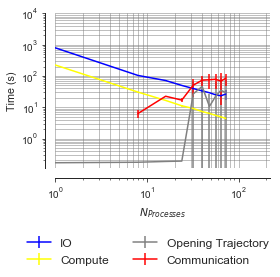

In [49]:
from matplotlib.pyplot import *
import matplotlib
plt.rcParams['font.size'] = 9
fig = plt.figure(figsize=(4,4))
axes = fig.add_subplot(1,1,1)

yerrs = [df_std_repeat['std_t_IO'].values.transpose().tolist(),df_std_repeat['std_t_comp'].values.transpose().tolist(),
         df_std_repeat['std_t_init'].values.transpose().tolist(),df_std_repeat['std_comm'].values.transpose().tolist()]

df_avg_repeat.index = df_avg_repeat.loc[:,'blocks']
df_avg_repeat['Communication'][1] = np.nan
df_avg_repeat.loc[:,['t_IO','t_comp','t_init','Communication']].plot(color=['blue','yellow','grey','red'],yerr=yerrs,ax=axes) 

plt.style.use('ggplot')
sns.set_style('ticks')
axes.set_xlabel('$N_{Processes}$')   
axes.set_ylabel('Time (s)')
plt.xscale('log')
plt.yscale('log')

axes.set_ylim(0, 10000)
axes.set_xlim(1, 220)
axes.yaxis.grid(which='major', linewidth='0.5', color='grey')
axes.xaxis.grid(which='major', linewidth='0.5', color='grey')
axes.yaxis.grid(which='minor', linewidth='0.5', color='grey')
axes.xaxis.grid(which='minor', linewidth='0.5', color='grey') 
sns.despine(offset=10, ax=axes)

lgd = plt.legend(['IO','Compute','Opening Trajectory','Communication'],loc='upper center', bbox_to_anchor=(0.43, -0.38),
                 frameon=False, shadow=False, ncol=2, prop={'size':12})
plt.tight_layout()
fig.subplots_adjust(bottom=0.4)

fig.savefig('{}.pdf'.format('time_comp_IO_comparison'))

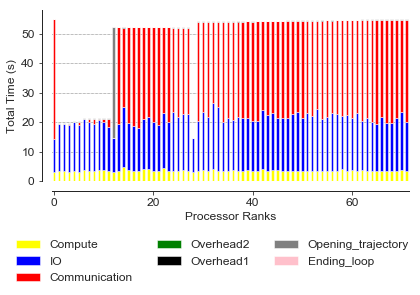

In [51]:
block = 72   # Number of processes (N_p) 
repeat = 5   # The repeat number (1-5)
fig_name = 'BarPlot-rank-comparison_{}_{}'.format(block,repeat)
df_comm_dist = df_comm_rank[(df_comm_rank[0]==block) & (df_comm_rank[1]==repeat)].iloc[0,2:block+2]
df_comm_dist.index = range(2,block+2)
df_compute_all_frame_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_comp']
df_compute_all_frame_rank.index = range(2,block+2)
df_IO_all_frame_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_IO']
df_IO_all_frame_rank.index = range(2,block+2)
df_IO_plus_comp_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_IO_plus_t_comp']
df_IO_plus_comp_rank.index = range(2,block+2)
df_clone_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_init']
df_clone_rank.index = range(2,block+2)
df_end_loop_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_end_loop']
df_end_loop_rank.index = range(2,block+2)
df_overhead1 = df_IO_plus_comp_rank.iloc[:]-df_IO_all_frame_rank.iloc[:]-df_compute_all_frame_rank.iloc[:]-df_end_loop_rank.iloc[:]
df_overhead1.index = range(2,block+2)
df_overhead2 = (df_comp_rank[(df_comp_rank[0]==block) & (df_comp_rank[1]==repeat)].iloc[0,2:block+2]-
                              df_IO_plus_comp_rank.iloc[:]-df_clone_rank.iloc[:])
df_overhead2.index = range(2,block+2)

ax = df_compute_all_frame_rank.plot(kind='bar', figsize=(6,4), color='yellow', label='Compute')
ax = df_IO_all_frame_rank.plot(kind='bar', figsize=(6,4), color='blue', label='IO', bottom = df_compute_all_frame_rank)
ax = df_comm_dist.plot(kind='bar', figsize=(6,4), color='red', label='Communication', bottom = 
                       [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j] for j in range(len(df_compute_all_frame_rank))])

ax = df_overhead2.plot(kind='bar', figsize=(6,4), color='green', label='Overhead2', bottom = 
                       [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j]+df_comm_dist.iloc[j] 
                        for j in range(len(df_compute_all_frame_rank))])

ax = df_overhead1.plot(kind='bar', figsize=(6,4), color='black', label='Overhead1', bottom = 
                       [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j]+df_comm_dist.iloc[j]+
                        df_overhead2.iloc[j] for j in range(len(df_compute_all_frame_rank))])

ax = df_clone_rank.plot(kind='bar', figsize=(6,4), color='gray', label='Opening_trajectory', bottom = 
                       [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j]+df_comm_dist.iloc[j]+
                        df_overhead2.iloc[j]+df_overhead1.iloc[j] for j in range(len(df_compute_all_frame_rank))])

ax = df_end_loop_rank.plot(kind='bar', figsize=(6,4), color='pink', label='Ending_loop', bottom = 
                          [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j]+df_comm_dist.iloc[j]+
                           df_overhead2.iloc[j]+df_overhead1.iloc[j]+df_clone_rank.iloc[j] for j in range(len(df_compute_all_frame_rank))])

ax.yaxis.grid(which='major',linestyle=':', linewidth='0.5', color='black')

plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
ax.set_xlabel('Processor Ranks')   
ax.set_ylabel('Total Time (s)')
sns.despine(offset=10, ax=ax)

plt.tight_layout()
plt.xticks(range(0,block,20), range(0,block,20))
fig = ax.get_figure()
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.28), frameon=False, shadow=True, ncol=3, prop={'size':12})
plt.gcf().subplots_adjust(bottom=0.35)
fig.savefig('{}.pdf'.format(fig_name), bbox_inches='tight')

In [53]:
def plot_dataframe(y, yerr, fig_name, ylabel, ylim, log): 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 9
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(1,1,1)
    df7.plot(y=y, x='blocks', yerr=yerr, ax=ax, marker='o', lw=2, label='Comet')
    if (y == 'speed_up'):
        df7.plot(y='Ideal_Scaling', x='blocks', ax=ax, linestyle='--', color='k', lw=2)
    if (y == 'efficiency'):
        df7.plot(y='Ideal_Efficiency', x='blocks', ax=ax, linestyle='--', color='k', lw=2)      
        
    ax.set_xlabel('$N_{Processes}$')   
    ax.set_ylabel(ylabel)
    if log == 'True':
        ax.loglog([1,72], [df7['t_tot_max'][0], df7['t_tot_max'][0]/72.], '--', label='Ideal',color='black')
        plt.yscale('log')
        plt.xscale('log') 
    else:
        ax.set_xlim([1,72])
        ax.set_ylim(ylim)  
        
    ax.yaxis.grid(which='major',linestyle=':', linewidth='0.5', color='black')
    ax.xaxis.grid(which='major',linestyle=':', linewidth='0.5', color='black')
    ax.yaxis.grid(which='minor',linestyle=':', linewidth='0.5', color='black')
    ax.xaxis.grid(which='minor',linestyle=':', linewidth='0.5', color='black')    
        
    ax.legend().set_visible(False)
    sns.despine(offset=10, ax=ax)
    plt.tight_layout() 
    fig.savefig('{}.pdf'.format(fig_name))

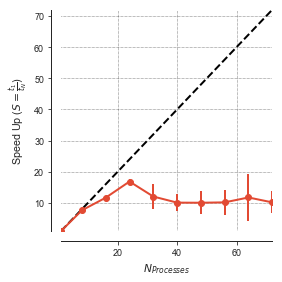

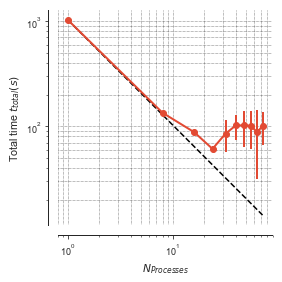

In [55]:
plot_dataframe('speed_up', 'std_S', 'speed_up', r'Speed Up ($S=\frac{t_{1}}{t_{N}}$)', [1,72],'False')
# plot_dataframe('efficiency', 'std_E', 'Efficiency', r'Efficiency ($\frac{S}{N}$)', [0,1.1],'False')
# plot_dataframe('t_block_RMSD_mean', 'std_t_block_RMSD_mean' , 't_block_RMSD_mean', '$t_{RMSD}(s)$', [0,1050],'True')
# plot_dataframe('t_comm_mean', 'std_t_comm_mean' , 't_comm_mean', '$t_{communication}(s)$', [0,150],'True')
# plot_dataframe('t_block_RMSD_max', 'std_t_block_RMSD_max' , 't_block_RMSD_max', '$t_{RMSD}(s)$', [0,1050],'True')
plot_dataframe('t_tot_max', 'std_tot_max', 't_total', 'Total time $t_{total}(s)$', [0,1050],'True')